In [1]:
# Processing
import json
from html.parser import HTMLParser
from bs4 import BeautifulSoup

# Data Science
import pandas as pd
import matplotlib.pyplot as plt

# Introduction to Digital Forensics - Assignment 1

In this assignment, we investigate a black market and the items offered in that black market. We decided to choose the Silk Road for our investigation.

After downloading the TOR browser, we opened the website and looked for the products. We realized that it would take a long time to write down all the information so we decided to write a couple of scripts to helps us save the information

Contributors:
- Carlos de Bourbon de Parme
- Vera Schockemöhle
- Floor Schutrups
- Jelle Hulter
- Nora Yigit
- Arda Öz

## Acquiring the Data

Our first step was to write a javascript code on the browser to save HTML contents of the webpages containing the products. The script requested several pages of products from the website and then saved the HTML contents of these pages in a JSON file.

We then exported this JSON file for further processing. After exporting the HTML contents, we wrote a python script to parse the information about the contents:

In [2]:
read_from_file = 'html_contents.json'
write_to_file  = 'products.csv'

with open(read_from_file, encoding="utf8") as f:
    data = json.load(f)

with open(write_to_file, 'w', encoding="utf8") as f:
    f.write("name;vendor;category;shippingCountry;dollars;positiveRating;negativeRating;rating\n")

    for page in data:
        parsed = BeautifulSoup(page)
        products = parsed.find_all('div', {'style': 'min-width:300px'})  
        for product in products:
            
            ss = []
            ss.append(product.find_all('a')[0].get_text())
            ss.append(product.find('span', {'id': 'ah_name'}).a.get_text())
            ss.append(product.find_all('a')[3].get_text())
            ss.append(product.find('span', {'id': 'ah_ships'}).get_text())
            ss.append(product.find_all('b')[-1].get_text().split()[0][1:])
            ratings = product.find('span', {'id': 'ah_score'}).get_text().split(', ')
            ratings = [ratings[0][1:], ratings[1][1:], ratings[2][:-1]]
            ss.extend(ratings)
            ss = [s.strip() for s in ss]
            f.write("%s\n"%";".join(ss))

Once the code cell above is run, we now have a csv file in our directory. We can load this file as a DataFrame to inspect its structure.

Users on GitHub may not be able to run the code cell above because we decided not to add the json file we generated using `javascript` to the repository.

In [3]:
df = pd.read_csv(write_to_file, delimiter=';')
df

,name,vendor,category,shippingCountry,dollars,positiveRating,negativeRating,rating
0,"LEVEL 1 - FULL Ounce $160 **Dutch, CandyLand**",DroDodo,Weed,United States,160,2485,0,100
1,12 x 250ug LSD tabs (stamps) - FREE SHIPPING,Streetlegend,LSD,Netherlands,65,1420,10,99
2,disneyplus account,levelup,Accounts,United States,10,1516,0,100
3,Blue Magic Uncut Cocaine 95% Pure Coke from Pe...,bluemagic,Cocaine,United Kingdom,75,18313,42,100
4,1GR ULTRA CLEAN QUALITY COCAINE 95% #1,ViceKings,Cocaine,Netherlands,60,18083,236,99
...,...,...,...,...,...,...,...,...
160,top brandedible skittles edibles 500 mg,levelup,Edibles,United States,10,1516,0,100
161,[AU✈AU] ♛FLASH SALE♛ 1 G MDMA – PURE HOLLAND I...,Hilfiger,MDMA,Australia,90,1970,5,100
162,1 Gram DMT Free Shipping,vintage,DMT,Netherlands,70,620,20,97
163,MASERATI 2CB 22MG PILLS XTC Ecstasy MDMA 2C-B ...,bluemagic,2C,United Kingdom,50,18313,42,100


## Labeling Legal or Illegal Items 

Before labeling the products, we observed that the website has seperated the drugs to different categories. We wanted to join all the drugs into a single category. To do this, we added another column to our dataframe called `main_category`:

In [4]:
non_drug_dictionary = {
    'Others': 'Others',
    'Concentrates': 'Concentrates',
    'CC/CVV': 'CC/CVV',
    'PayPal': 'PayPal',
    'Edibles': 'Edibles',
    'Mushrooms': 'Mushrooms',
    'Accounts': 'Accounts',
    'Services': 'CC/CVV',
    'eBooks': 'CC/CVV'
}

main_category_dictionary = {category:'Drug' if category not in non_drug_dictionary else non_drug_dictionary[category] for category in df['category'].unique()}

df['main_category'] = df['category'].map(main_category_dictionary)

To label the products as legal or illegal, we first labelled the hard drugs as illegal. You can see the dataframe down below:

In [5]:
# adding new columns
df['legal'] = True
df['legality_reason'] = 'not specified'

# labeling the hard drugs
df.loc[(df['main_category'] == 'Drug') & ((df['category'] != 'Weed') & (df['category'] != 'Hash')), 'legal'] = False
df.loc[(df['main_category'] == 'Drug') & ((df['category'] != 'Weed') & (df['category'] != 'Hash')), 'legality_reason'] = 'hard drug'
df

,name,vendor,category,shippingCountry,dollars,positiveRating,negativeRating,rating,main_category,legal,legality_reason
0,"LEVEL 1 - FULL Ounce $160 **Dutch, CandyLand**",DroDodo,Weed,United States,160,2485,0,100,Drug,True,not specified
1,12 x 250ug LSD tabs (stamps) - FREE SHIPPING,Streetlegend,LSD,Netherlands,65,1420,10,99,Drug,False,hard drug
2,disneyplus account,levelup,Accounts,United States,10,1516,0,100,Accounts,True,not specified
3,Blue Magic Uncut Cocaine 95% Pure Coke from Pe...,bluemagic,Cocaine,United Kingdom,75,18313,42,100,Drug,False,hard drug
4,1GR ULTRA CLEAN QUALITY COCAINE 95% #1,ViceKings,Cocaine,Netherlands,60,18083,236,99,Drug,False,hard drug
...,...,...,...,...,...,...,...,...,...,...,...
160,top brandedible skittles edibles 500 mg,levelup,Edibles,United States,10,1516,0,100,Edibles,True,not specified
161,[AU✈AU] ♛FLASH SALE♛ 1 G MDMA – PURE HOLLAND I...,Hilfiger,MDMA,Australia,90,1970,5,100,Drug,False,hard drug
162,1 Gram DMT Free Shipping,vintage,DMT,Netherlands,70,620,20,97,Drug,False,hard drug
163,MASERATI 2CB 22MG PILLS XTC Ecstasy MDMA 2C-B ...,bluemagic,2C,United Kingdom,50,18313,42,100,Drug,False,hard drug


In total, 118 of the products out of 165 are hard drugs:

In [6]:
df['legal'].value_counts()

False    118
True      47
Name: legal, dtype: int64

The rest were labeled by hand:

## Labeling Categories

The website was kind enough to provide us with the category information of the products. We extracted this information from the website while parsing it.

We started visualising our results with a quick pie chart:

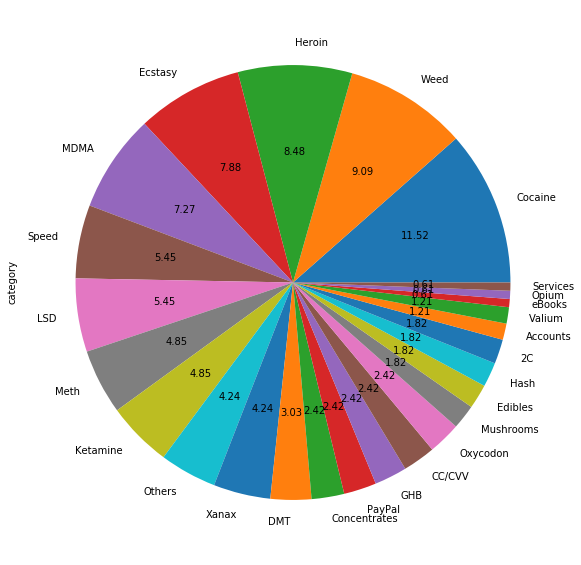

In [7]:
df['category'].value_counts().plot.pie(figsize=(10,10), autopct=lambda x: '%.2f'%x)
plt.show()

Using the `main_category`, we can now display the share of the products on the website once again. We can also show the shares of drugs:

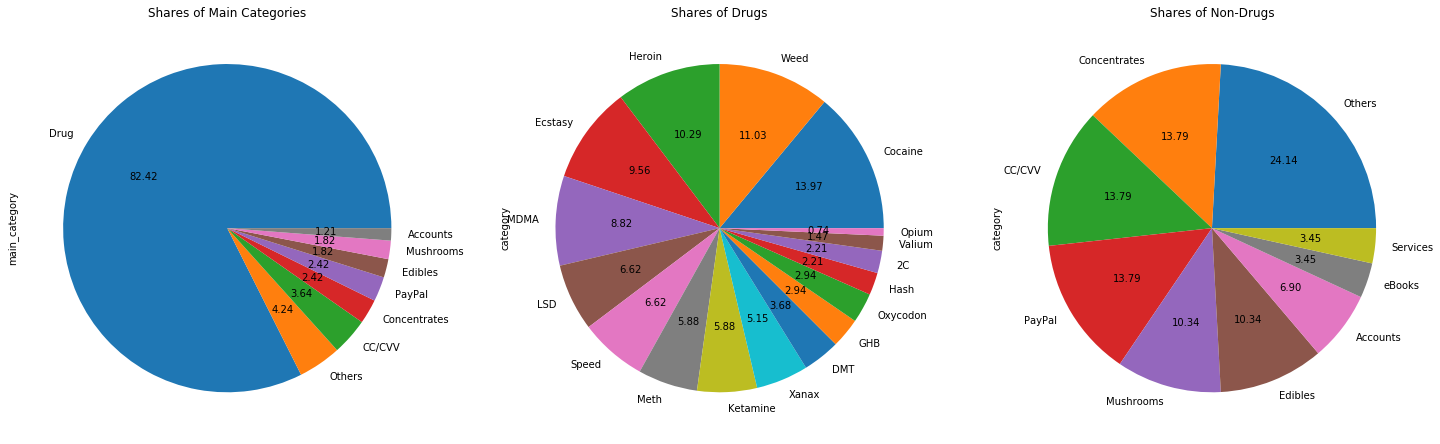

In [8]:
fig, ax = plt.subplots(1,3, figsize = (25, 15))

ax[0].title.set_text("Shares of Main Categories")
df['main_category'].value_counts().plot.pie(ax=ax[0], autopct=lambda x: '%.2f'%x)

ax[1].title.set_text("Shares of Drugs")
df[df['main_category'] == 'Drug']['category'].value_counts().plot.pie(ax=ax[1], autopct=lambda x: '%.2f'%x)

ax[2].title.set_text("Shares of Non-Drugs")
df[df['main_category'] != 'Drug']['category'].value_counts().plot.pie(ax=ax[2], autopct=lambda x: '%.2f'%x)
plt.show()

In the pie chart down below, you can also see the percentage of drugs:

## Investigating Countries

First thing we wanted to observe was the share of each country:

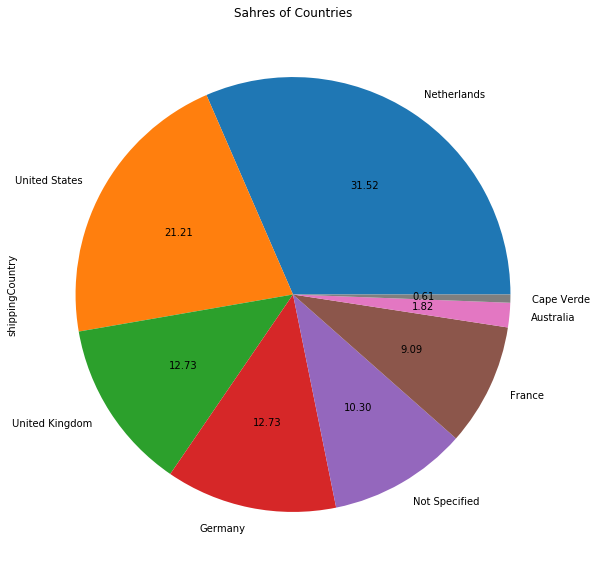

In [9]:
df['shippingCountry'].value_counts().plot.pie(figsize=(10,10), autopct=lambda x: '%.2f'%x)
plt.title("Sahres of Countries")
plt.show()

Below, we also show what products each country ships to this black market:

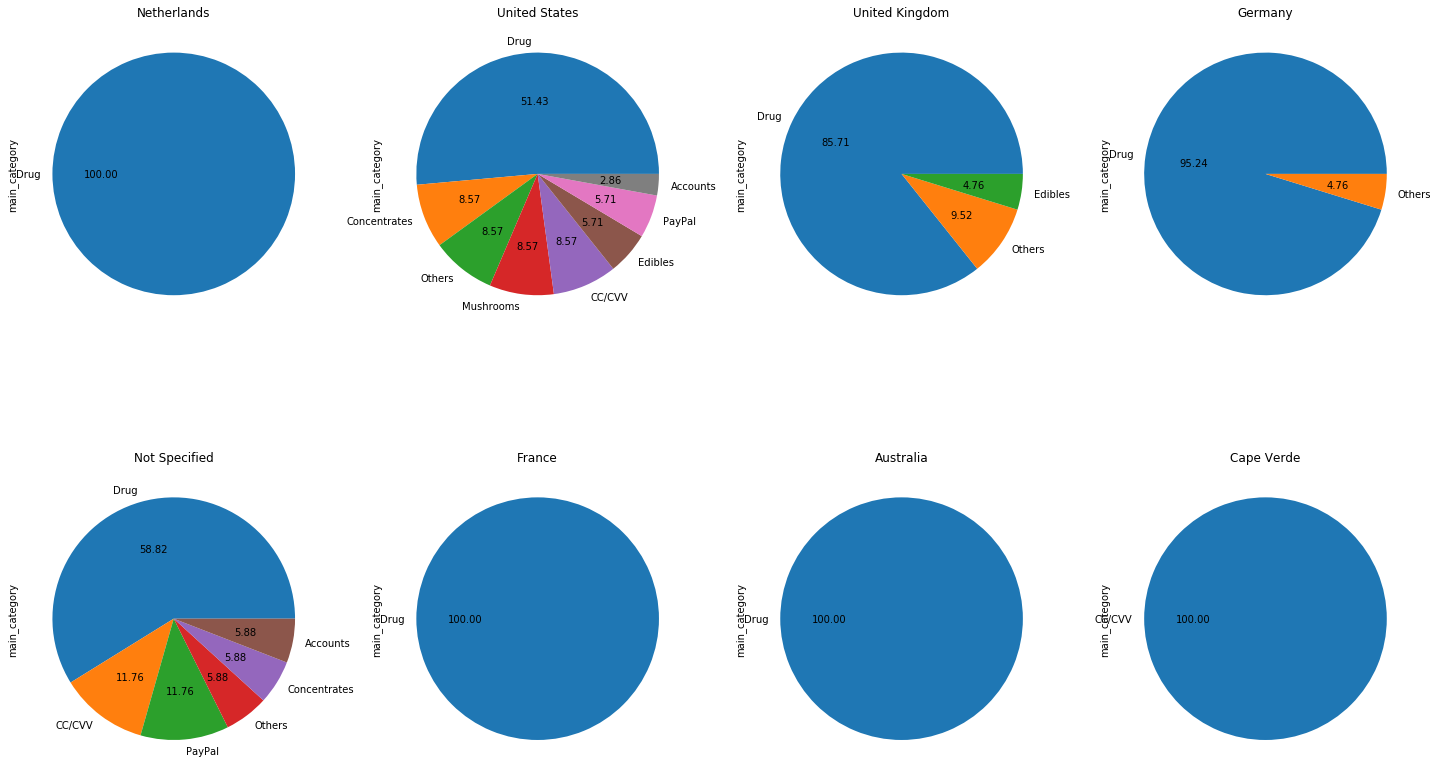

In [10]:
fig, ax = plt.subplots(2,4, figsize = (25, 15))

for i, country in enumerate(df['shippingCountry'].value_counts().index):
    ax[i//4, i%4].title.set_text(country)
    df[df['shippingCountry'] == country]['main_category'].value_counts().plot.pie(ax = ax[i//4, i%4], autopct=lambda x: '%.2f'%x)
plt.show()

## Top 10 Sellers

Before investigating the vendors, we found it beneficial to find out which vendors are the top 10 vendors. The features we generate in this section will be beneficial when we start investigating the vendors.

There are different ways of evaluating the vendors to choose the top 10. One option is to order by the number of products. Down below, you can see the top 10 vendors based on this metric. You can also see the statistics about each vendor:

In [11]:
groupedby_vendor = df.groupby('vendor').mean()
groupedby_vendor['n_products'] = df['vendor'].value_counts()
groupedby_vendor = groupedby_vendor.sort_values('n_products', ascending=False)
groupedby_vendor.head(10)

,dollars,positiveRating,negativeRating,rating,legal,n_products
vendor,,,,,,
WeAreAMSTERDAM,93.307692,28944.0,209.0,99.0,0.153846,13
Flako,34.666667,7070.0,61.0,99.0,0.000000,12
bluemagic,56.250000,18313.0,42.0,100.0,0.166667,12
MisterGreen,48.666667,1390.0,20.0,99.0,0.666667,9
JimmJoness,37.285714,1849.0,55.0,97.0,0.428571,7
Lidl,77.333333,6510.0,51.0,99.0,0.000000,6
MyINI,189.000000,22809.0,96.0,100.0,0.200000,5
theolddoctor,68.800000,1362.0,15.0,99.0,0.000000,5
marcopolo1969,23.800000,2573.0,0.0,100.0,0.600000,5


Another option is to estimate the sales of each vendor looking at the number of ratings they have received and multiplying this number with the average product cost for the vendor. This would give us an estimate volume for each vendor:

In [12]:
groupedby_vendor['volume'] = groupedby_vendor['dollars'] * groupedby_vendor[['positiveRating', 'negativeRating']].sum(axis=1)
groupedby_vendor.sort_values('volume', ascending=False).head(10)

,dollars,positiveRating,negativeRating,rating,legal,n_products,volume
vendor,,,,,,,
MyINI,189.000000,22809.0,96.0,100.0,0.200000,5,4.329045e+06
WeAreAMSTERDAM,93.307692,28944.0,209.0,99.0,0.153846,13,2.720199e+06
ViceKings,60.000000,18083.0,236.0,99.0,0.000000,1,1.099140e+06
bluemagic,56.250000,18313.0,42.0,100.0,0.166667,12,1.032469e+06
Dimma,260.000000,2692.0,15.0,99.0,0.000000,1,7.038200e+05
Ondemand,75.000000,8561.0,33.0,100.0,0.333333,3,6.445500e+05
Lidl,77.333333,6510.0,51.0,99.0,0.000000,6,5.073840e+05
Cafenero,140.000000,3132.0,11.0,100.0,1.000000,2,4.400200e+05
procarder7,27.500000,13217.0,122.0,99.0,1.000000,4,3.668225e+05


We can use the volume column and the number of products column to plot to following plot. Each dot represents a vendor. The x axis is the number of products in the market and the y axis is the volume estimate. 

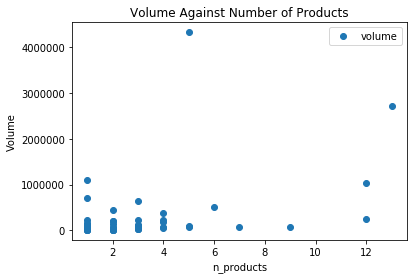

In [13]:
groupedby_vendor.plot(x='n_products', y='volume', style='o', title="Volume Against Number of Products")
plt.ylabel("Volume")
plt.show()

We observe that there are 4 distinct vendors in our dataset. WeAreAMSTERDAM, Flako and bluemagic with 12 to 13 products and MyINI with a huge volume.

We also tried using the vendor rating to find the top 10 but we realized that it is not a good metric. This is because the ratings of vendors are saturated with values close to 100. This can be seen in the next plot.

## Focusing on the Vendors

Distribution of the vendor ratings:

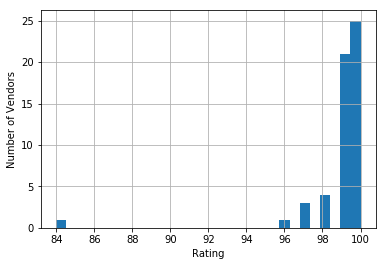

In [14]:
groupedby_vendor['rating'].hist(bins=30)
plt.ylabel("Number of Vendors")
plt.xlabel("Rating")
plt.show()

Next thing we wanted to investigate was to draw box plots to visulalize the distributions of product costs for each vendor. We decided to only use the top 10 vendors with the most products:

C:\Users\user\anaconda3\envs\tensor\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


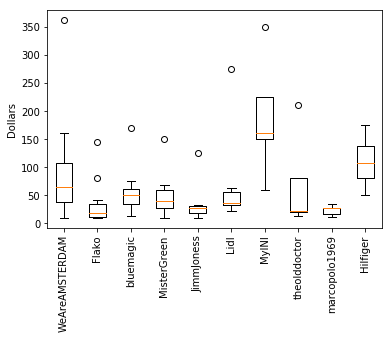

In [15]:
plt.boxplot([df[df['vendor'] == vendor]['dollars'] for vendor in groupedby_vendor.index[:10]],
    labels=groupedby_vendor.index[:10])
plt.xticks(rotation=90)
plt.ylabel("Dollars")
plt.show()

## Products that Surprised Us

(3 products)

In [16]:
#df[df['legal']==True][['name']].to_csv('legality.csv', index=False)